# Whole Slide Image sampler module: 
## this notebook == first successfull full round trip test

****
## Testing with:
```python
tensorflow==2.0.0rc0
```
social thing to do: <br>
email construction <br>
slides as html or pdf or google slides <br>

In [62]:
import IPython.display as ip_display
import os

file_ext_list = ['.svs', '.tif', '.tiff']
def get_file_size_dict(data_dir, reverse_dict=False):
    """ Usage:
    file_size_dict = get_file_size_dict(data_dir)
    """
    file_size_dict = {}
    for f in os.listdir(data_dir):
        ff = os.path.join(data_dir, f)
        if os.path.isfile(ff): 
            _, f_ext = os.path.splitext(ff)
            if f_ext in file_ext_list:
                file_size_dict[ff] = os.path.getsize(ff)
                
    return file_size_dict

data_dir = '../../DigiPath_MLTK_data/Aperio'
file_size_dict = get_file_size_dict(data_dir)
for f, sz in file_size_dict.items():
    print('%60s: %s'%(f,sz))


            ../../DigiPath_MLTK_data/Aperio/JP2K-33003-2.svs: 289250433
            ../../DigiPath_MLTK_data/Aperio/JP2K-33003-1.svs: 63847265
        ../../DigiPath_MLTK_data/Aperio/CMU-1-JP2K-33005.svs: 132565343
                   ../../DigiPath_MLTK_data/Aperio/CMU-1.svs: 177552579
                   ../../DigiPath_MLTK_data/Aperio/CMU-3.svs: 253815723
      ../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs: 1938955
                   ../../DigiPath_MLTK_data/Aperio/CMU-2.svs: 390750635


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import os
from tempfile import TemporaryDirectory

import numpy as np
import openslide
from skimage.filters import threshold_otsu
import PIL

WORKING_THUMB_MAX_SIZE = [2048, 2048]
WORKING_THUMB_MIN_SIZE = [1024, 1024]


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def image_example(image_string, label):
    """ image_metadat_dict = image_example(image_string, label)
    Create a dictionary of jpg image features
    """
    image_shape = tf.image.decode_jpeg(image_string).shape

    feature = {'height': _int64_feature(image_shape[0]),
               'width': _int64_feature(image_shape[1]),
               'depth': _int64_feature(image_shape[2]),
               'label': _int64_feature(label),
               'image_raw': _bytes_feature(image_string) }

    return tf.train.Example(features=tf.train.Features(feature=feature))


def raw_jpg_to_tfrecord(image_labels_dict, file_name='slide_images.tfrecords'):
    """ raw_jpg_to_tfrecord(image_labels_dict, file_name)
    write a jpg image to to a tfrecord
    """
    with tf.io.TFRecordWriter(file_name) as writer:
        for filename, label in image_labels_dict.items():
            image_string = open(filename, 'rb').read()
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())


def get_adjcent_segmented_length_fence_array(segment_length, length):
    """ fences = get_adjcent_segmented_length_fence_array(segment_length, length)
    """
    fences = {}
    n_fenced = length // segment_length
    n_remain = 1 + length % segment_length
    paddit = n_remain // 2
    if n_remain == segment_length:
        paddit = 0
        n_remain = 0
        n_fenced = n_fenced + 1
    
    fence_array = np.zeros((n_fenced, 2)).astype(int)
    for k in range(n_fenced):
        if k == 0:
            fence_array[k, 0] = paddit
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        elif fence_array[k-1, 1] + segment_length <= length:
            fence_array[k, 0] = fence_array[k-1, 1] + 1
            fence_array[k, 1] = fence_array[k, 0] + segment_length - 1
        
    fences['fence_array'] = fence_array
    fences['n_fenced'] = n_fenced
    fences['n_remain'] = n_remain
    fences['padding'] = paddit

    return fences


        
def get_patch_name_from_row_col(row, col, base_name='patch', file_ext='.jpg'):
    """ patch_name = get_patch_name_from_row_col(row, col, base_name='patch', 
                                                file_ext='.jpg') 
    """
    if file_ext[0] != '.':
        file_ext = '.' + file_ext
    patch_name = base_name + '_row_%i_%i'%(row[0], row[1])
    patch_name += '_col_%i_%i%s'%(col[0], col[1], file_ext)
    
    return patch_name


def get_row_col_from_patch_name(fname):
    """ row_col_dict = get_row_col_from_filename(fname) 
    """
    row_label = 'row'
    col_label = 'col'
    r = []
    c = []
    base_name, file_ext = os.path.splitext(os.path.split(fname)[1])
    parts_list = base_name.split('_')
    
    for i in range(len(parts_list)):
        if parts_list[i] == row_label:
            r.append(parts_list[i+1])
            r.append(parts_list[i+2])
        elif parts_list[i] == col_label:
            c.append(parts_list[i+1])
            c.append(parts_list[i+2])
    row = np.array(r).astype(np.int)
    col = np.array(c).astype(np.int)
    return {'base_name': parts_list[0], 'file_ext': file_ext, 'row': row, 'col': col }


def get_mask_w_scale_grid(os_obj, patch_height, patch_width):
    """ mask_dict = get_mask_w_scale_grid(svs_file_name, patch_height, patch_width)
    
    """
    close_os_obj = False
    if isinstance(os_obj, str) and os.path.isfile(os_obj):
        os_obj = openslide.OpenSlide(svs_file_name)
        close_os_obj = True
    
    #                               get the indexing arrays for the full size grid
    pixels_height = os_obj.dimensions[0]
    pixels_width = os_obj.dimensions[1]

    full_scale_rows_dict = get_adjcent_segmented_length_fence_array(segment_length=patch_height, 
                                                                    length=pixels_height)
    full_scale_cols_dict = get_adjcent_segmented_length_fence_array(segment_length=patch_width, 
                                                                    length=pixels_width)
    full_scale_rows_arrays = full_scale_rows_dict['fence_array']
    full_scale_cols_arrays = full_scale_cols_dict['fence_array']

    
    #                               determine thumbnail size & get the mask
    pixels_height_ds = os_obj.level_dimensions[-1][0]
    pixels_width_ds = os_obj.level_dimensions[-1][1]
    scale_determinant = max(pixels_height_ds, pixels_width_ds)
    
    thumbnail_divisor = 1
    don_t_b_dum = 10
    count = 0
    
    while scale_determinant // thumbnail_divisor > WORKING_THUMB_MAX_SIZE[0] and count < don_t_b_dum:
        count += 0
        thumbnail_divisor *= 2
    
    thumb_height = pixels_height_ds // thumbnail_divisor
    thumb_width = pixels_width_ds // thumbnail_divisor
    
    #                               get the indexing arrays for the thumbnail sized grid
    rows_divisor = pixels_height / thumb_height
    thumb_scale_rows_arrays = (full_scale_rows_arrays // rows_divisor).astype(int)
    cols_divisor = pixels_width / thumb_width
    thumb_scale_cols_arrays = (full_scale_cols_arrays // cols_divisor).astype(int)

    #                               git the mask image
    one_thumb = os_obj.get_thumbnail((thumb_height, thumb_width))
    grey_thumbnail = np.array(one_thumb.convert('L'))
    thresh = threshold_otsu(grey_thumbnail)
    mask = np.array(grey_thumbnail) < thresh
    mask_im = PIL.Image.fromarray(np.uint8(mask) * 255)

    if close_os_obj == True:
        os_obj.close()
        
    mask_dict = {'thumb_mask': mask_im, 
                 'full_scale_rows_dict': full_scale_rows_dict, 
                 'full_scale_cols_dict': full_scale_cols_dict, 
                 'full_scale_rows_arrays': full_scale_rows_arrays, 
                 'full_scale_cols_arrays': full_scale_cols_arrays,
                 'thumb_scale_rows_arrays': thumb_scale_rows_arrays, 
                 'thumb_scale_cols_arrays': thumb_scale_cols_arrays}
    
    return mask_dict


In [58]:
"""
"""
import time
from tempfile import TemporaryDirectory

def svs_file_to_patches_tfrecord(svs_file_name, output_dir, patch_size, patch_keep_threshold):
    """ 
    mask_dict = svs_file_to_patches_tfrecord(svs_file_name, output_dir, patch_height, patch_width=None)
    """
#     walk_start_time = time.time()                                       #_______________<o>.<o>----------------
    _, file_name_base = os.path.split(svs_file_name)
    file_name_base, _ = os.path.splitext(file_name_base)
    tfrecord_file_name = file_name_base + '.tfrecords'
    tfrecord_file_name = os.path.join(output_dir, tfrecord_file_name)
    file_ext = '.jpg'
    print('file_name_base', file_name_base, 
          '\nfile extension', file_ext, 
          '\ntfrecord_file_name', tfrecord_file_name)
    print('\nopening:\n', svs_file_name, '\nwrite to:\n', output_dir)
    
    patch_height = patch_size[0]
    patch_width = patch_size[1]
    print('patch_height: %i, patch_width:%i'%(patch_height, patch_width))
    
    os_obj = openslide.OpenSlide(svs_file_name)
    mask_dict = get_mask_w_scale_grid(os_obj, patch_height, patch_width)
    mask_im = mask_dict['thumb_mask']
    
    full_scale_rows_arrays = mask_dict['full_scale_rows_arrays']
    full_scale_cols_arrays = mask_dict['full_scale_cols_arrays']
    print('image height %i, width %i'%(os_obj.dimensions[0],os_obj.dimensions[1]))
    print('full_scale_rows_arrays.shape', full_scale_rows_arrays.shape)
    print('full_scale_cols_arrays.shape', full_scale_cols_arrays.shape)
    
    thumb_scale_rows_arrays = mask_dict['thumb_scale_rows_arrays']
    thumb_scale_cols_arrays = mask_dict['thumb_scale_cols_arrays']
    
    seq_number = 0
    with TemporaryDirectory() as temp_dir:
        print('using temp_dir\n\t', temp_dir, '\n')
        with tf.io.TFRecordWriter(tfrecord_file_name) as writer:
            for row in range(full_scale_rows_arrays.shape[0]):
#                 if row % 10 == 0:                                     #_______________<o>.<o>----------------
#                     print('row %3i: %03f'%(row, time.time() - walk_start_time))
                for col in range(full_scale_cols_arrays.shape[0]):
                    r = thumb_scale_rows_arrays[row]
                    c = thumb_scale_cols_arrays[col]
                    area = (c[0], r[0], c[1], r[1])
                    thumb_segment = mask_im.crop(area)
                    thumb_arr = np.array(thumb_segment)
                    mask_value = np.float(np.sum(thumb_arr==0)) / np.float(np.prod(thumb_arr.shape))

                    if mask_value <= patch_keep_threshold:
                        #                         pass
                        #                     else:
                        fs_row = full_scale_rows_arrays[row]
                        fs_col = full_scale_cols_arrays[col]
                        patch_name = get_patch_name_from_row_col(fs_row, fs_col, file_name_base, file_ext)
                        print(patch_name)
                        patch_name = os.path.join(temp_dir, patch_name)

                        read_location = (full_scale_cols_arrays[col][0], full_scale_rows_arrays[row][0])
                        full_sect = os_obj.read_region(level=0, size=patch_size, 
                                                       location=read_location)
                        full_sect = full_sect.convert('RGB')
                        print('Yeah', seq_number, seq_number, seq_number)

                        full_sect.save(patch_name)
                        image_string = open(patch_name, 'rb').read()
                        tf_example_obj = image_example(image_string, label=seq_number)
                        writer.write(tf_example_obj.SerializeToString())
                        seq_number += 1

    svs_file_conversion_dict = {'mask_dict': mask_dict, 
                                'tfrecord_file_name': tfrecord_file_name, 
                                'number_of_patches': seq_number}
    
    return svs_file_conversion_dict

# Milestone test: 
    * choose a svs data file 
    * run the time test

In [56]:
data_dir = '../../DigiPath_MLTK_data/Aperio'
file_size_dict = get_file_size_dict(data_dir)

rev_file_size_dict = {v:k for k, v in file_size_dict.items()}

ordered_keys = sorted(list(rev_file_size_dict.keys()))
files_list = []
count = 0
print('\n\tordered by size:')
for k in ordered_keys:
    files_list.append(rev_file_size_dict[k])
    print('%3i %16i : %s'%(count, k, rev_file_size_dict[k]))
    count += 1

print('\n\n\tordered by list order:')
for f in files_list:
    _, f_only = os.path.split(f)
    print('%40s: %i'%(f_only, file_size_dict[f]))


	ordered by size:
  0          1938955 : ../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs
  1         63847265 : ../../DigiPath_MLTK_data/Aperio/JP2K-33003-1.svs
  2        132565343 : ../../DigiPath_MLTK_data/Aperio/CMU-1-JP2K-33005.svs
  3        177552579 : ../../DigiPath_MLTK_data/Aperio/CMU-1.svs
  4        253815723 : ../../DigiPath_MLTK_data/Aperio/CMU-3.svs
  5        289250433 : ../../DigiPath_MLTK_data/Aperio/JP2K-33003-2.svs
  6        390750635 : ../../DigiPath_MLTK_data/Aperio/CMU-2.svs


	ordered by list order:
                  CMU-1-Small-Region.svs: 1938955
                        JP2K-33003-1.svs: 63847265
                    CMU-1-JP2K-33005.svs: 132565343
                               CMU-1.svs: 177552579
                               CMU-3.svs: 253815723
                        JP2K-33003-2.svs: 289250433
                               CMU-2.svs: 390750635


In [59]:
# import time
svs_file_name = os.path.join(data_dir, files_list[0])
output_dir = '../../DigiPath_MLTK_data/module_test'
patch_height = 224
patch_width = 224
patch_size = [patch_height, patch_width]
patch_keep_threshold = 0.5

start_call_time = time.time()
svs_file_conversion_dict = svs_file_to_patches_tfrecord(svs_file_name, 
                                                             output_dir, 
                                                             patch_size, 
                                                             patch_keep_threshold)

tfrecord_file_name = svs_file_conversion_dict['tfrecord_file_name']
number_of_patches = svs_file_conversion_dict['number_of_patches']
mask_dict = svs_file_conversion_dict['mask_dict']
# ip_display.display(mask_dict['thumb_mask'])
total_run_time = time.time() - start_call_time
print('\n\ntfrecord_file_name\n\t%s\n%i patches in %0.3f seconds run time\n'%(tfrecord_file_name, 
                                                                              number_of_patches, 
                                                                              total_run_time))

file_name_base CMU-1-Small-Region 
file extension .jpg 
tfrecord_file_name ../../DigiPath_MLTK_data/module_test/CMU-1-Small-Region.tfrecords

opening:
 ../../DigiPath_MLTK_data/Aperio/../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs 
write to:
 ../../DigiPath_MLTK_data/module_test
patch_height: 224, patch_width:224
image height 2220, width 2967
full_scale_rows_arrays.shape (9, 2)
full_scale_cols_arrays.shape (13, 2)
using temp_dir
	 /var/folders/12/rq_vvnr91sj5kh6xj64x3vsr0000gn/T/tmprr95zcy6 

CMU-1-Small-Region_row_102_325_col_924_1147.jpg
Yeah 0 0 0
CMU-1-Small-Region_row_326_549_col_924_1147.jpg
Yeah 1 1 1
CMU-1-Small-Region_row_550_773_col_924_1147.jpg
Yeah 2 2 2
CMU-1-Small-Region_row_550_773_col_1148_1371.jpg
Yeah 3 3 3
CMU-1-Small-Region_row_550_773_col_1372_1595.jpg
Yeah 4 4 4
CMU-1-Small-Region_row_774_997_col_924_1147.jpg
Yeah 5 5 5
CMU-1-Small-Region_row_774_997_col_1148_1371.jpg
Yeah 6 6 6
CMU-1-Small-Region_row_774_997_col_1372_1595.jpg
Yeah 7 7 7
CMU-1-Small-Region

## View the tfrecord files:

<class 'dict'> tf.Tensor(0, shape=(), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'>


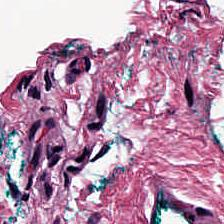

<class 'dict'> tf.Tensor(1, shape=(), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'>


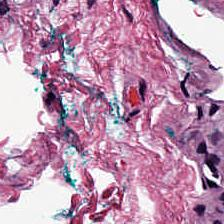

<class 'dict'> tf.Tensor(2, shape=(), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'>


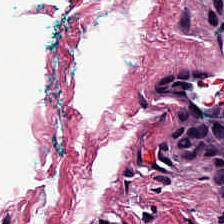

In [60]:
# tfr_name = '../../DigiPath_MLTK_data/module_test/CMU-1-Small-Region.tfrecords'
tfr_name = tfrecord_file_name
raw_image_dataset = tf.data.TFRecordDataset(tfr_name)
# raw_image_dataset = tf.data.get_output_classes('slide_images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
type(parsed_image_dataset)


n_to_show = 3
for dakine in parsed_image_dataset.take(n_to_show):
    print(type(dakine), dakine['label'], type(dakine['image_raw']))
    image_raw = dakine['image_raw'].numpy()
    ip_display.display(ip_display.Image(data=image_raw))


### Function Run-Tests: (prototype for unit tests)



test_fence_array_function
	get_adjcent_segmented_length_fence_array
	n pixels: 893 patch_length: 224

         fence_array:
                     111,    334
                     335,    558
                     559,    782
            n_fenced: 3
            n_remain: 222
             padding: 111


test_patch_names
CMU-1_row_11016_11239_col_30569_30792.jpg
CMU-1_row_11016_11239_col_30569_30792.jpg
[11016 11239] [30569 30792]
CMU-1 		 .jpg 

CMU-1_row_10792_11015_col_28105_28328.jpg
CMU-1_row_10792_11015_col_28105_28328.jpg
[10792 11015] [28105 28328]
CMU-1 		 .jpg 

CMU-1_row_3400_3623_col_29897_30120.jpg
CMU-1_row_3400_3623_col_29897_30120.jpg
[3400 3623] [29897 30120]
CMU-1 		 .jpg 

CMU-1_row_1608_1831_col_29225_29448.jpg
CMU-1_row_1608_1831_col_29225_29448.jpg
[1608 1831] [29225 29448]
CMU-1 		 .jpg 

CMU-1_row_7656_7879_col_28553_28776.jpg
CMU-1_row_7656_7879_col_28553_28776.jpg
[7656 7879] [28553 28776]
CMU-1 		 .jpg 


thumb_mask.size (1437, 1028)

rows: (205, 2) (205, 2) 
cols

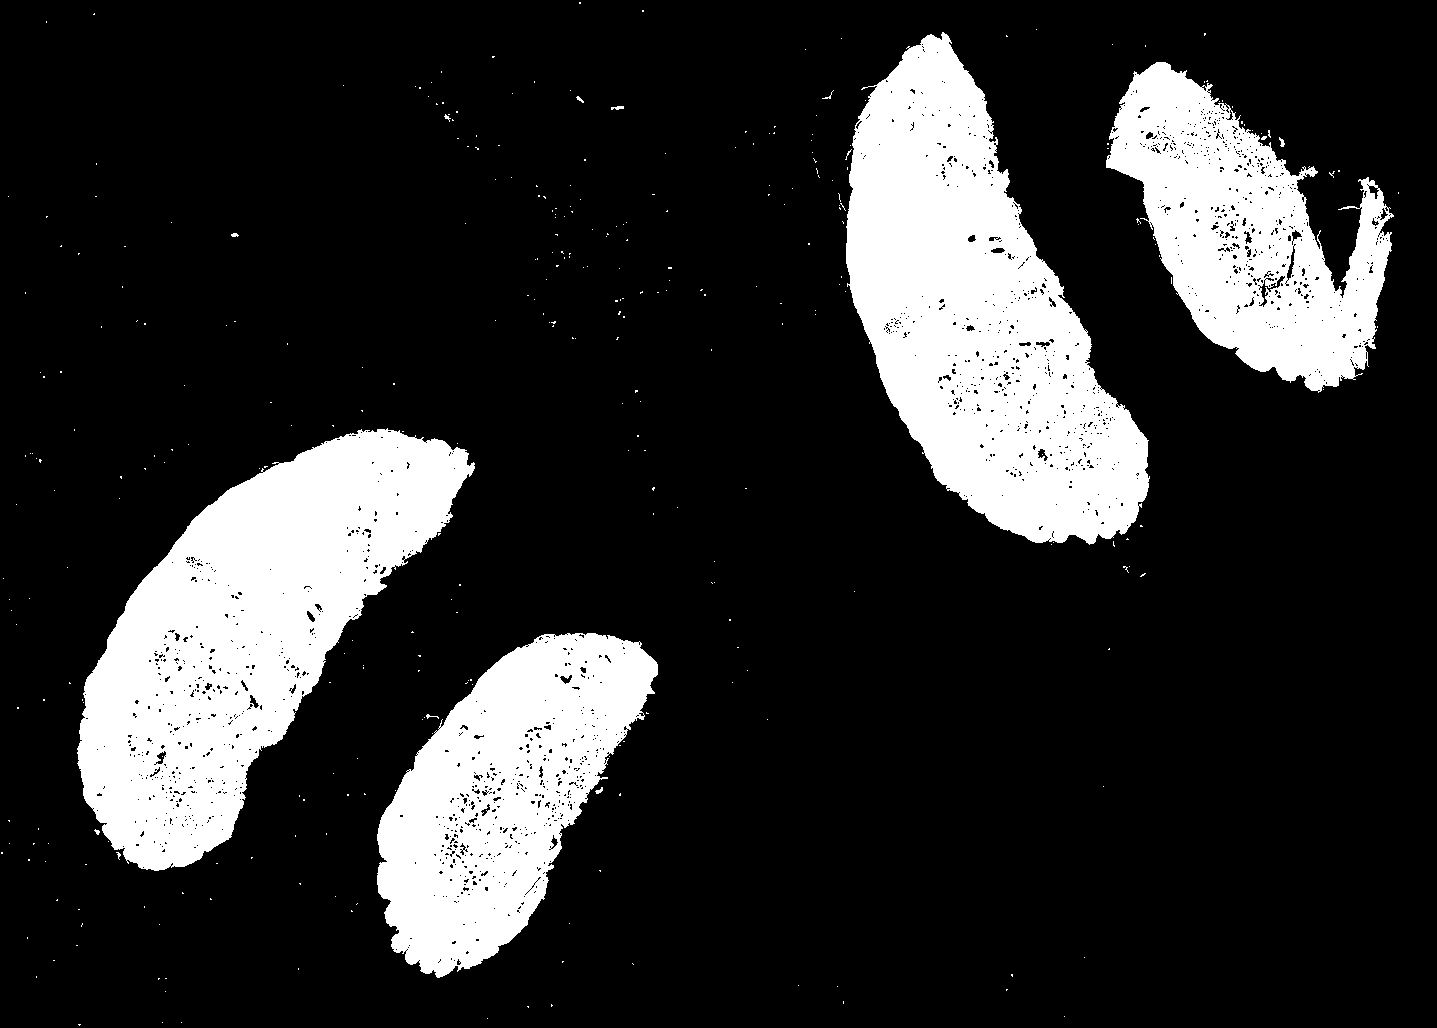

In [3]:
def test_fence_array_function():
    """ test_fence_array_function()
    """
    segment_length = 224
    length = segment_length*4 - 3

    print('\tget_adjcent_segmented_length_fence_array')
    print('\tn pixels: %i patch_length: %i\n'%(length, segment_length))
    fences_dict = get_adjcent_segmented_length_fence_array(segment_length, length)
    for k, v in fences_dict.items():
        if isinstance(v, np.ndarray):
            print('%20s:'%(k))
            for v_idx in range(v.shape[0]):
                if v[v_idx,1] - v[v_idx,0] != segment_length - 1:
                    print('%24s, %6i   Bug Bug'%(v[v_idx,0], v[v_idx,1]))
                else:
                    print('%24s, %6i'%(v[v_idx,0], v[v_idx,1]))
        else:
            print('%20s: %s'%(k,v))
            

def test_patch_names(out_test_dir):
    """ test_patch_names(out_test_dir)
    out_test_dir has jpg files named with the above naming functions
    """
    jpg_list = []
    for f in os.listdir(out_test_dir):
        _, f_ext = os.path.splitext(f)
        if f_ext == '.jpg':
            full_name = os.path.join(out_test_dir, f)
            if full_name in jpg_list:
                print('duplicate name: ???', full_name)
            else:
                jpg_list.append(full_name)

    n = 5
    for n in np.random.randint(0,999,5):
        _, one_name = os.path.split(jpg_list[n])
        print(one_name)
        rc_dict = get_row_col_from_patch_name(fname=jpg_list[n])

        bname = get_patch_name_from_row_col(rc_dict['row'],
                                            rc_dict['col'],
                                            rc_dict['base_name'],
                                            rc_dict['file_ext'])
        print(bname)
        print(rc_dict['row'], rc_dict['col'])
        print(rc_dict['base_name'], '\t\t', rc_dict['file_ext'], '\n')
        
print('test_fence_array_function')
test_fence_array_function()
out_test_dir = '../../DigiPath_MLTK_data/out_to_test'
print('\n\ntest_patch_names')
test_patch_names(out_test_dir)


#                                            run-test: get_mask_w_scale_grid
data_dir = '../../DigiPath_MLTK_data/Aperio'
files_list = ['CMU-1-Small-Region.svs', 'CMU-1.svs']

target_dir = '../../DigiPath_MLTK_data/out_to_test'
svs_file_name = os.path.join(data_dir, 'CMU-1.svs')

patch_height = 224
patch_width = 224

masked_dict = get_mask_w_scale_grid(svs_file_name, patch_height, patch_width)

big_r = masked_dict['full_scale_rows_arrays']
big_c = masked_dict['full_scale_cols_arrays']
sml_r = masked_dict['thumb_scale_rows_arrays']
sml_c = masked_dict['thumb_scale_cols_arrays']

thumb_mask = masked_dict['thumb_mask']
print('\nthumb_mask.size', thumb_mask.size)
print('\nrows:', big_r.shape, sml_r.shape, '\ncols:', big_c.shape, sml_c.shape, '\n')

n = 0
n_max = n+5
print('index\t[R,R] [C,C]\t[r,r] [c,c]')
for k in range(n, n_max):
    print(k, '\t', big_r[k,:], big_c[k,:], '\t', sml_r[k,:], sml_c[k,:])

n_rows = big_r.shape[0]
n_cols = big_c.shape[0]

for k in range(n_max, n, -1):
    kr = n_rows - k
    kc = n_cols - k
    print(kr, kc, '\t', big_r[kr,:], big_c[kc,:], '\t', sml_r[kr,:], sml_c[kc,:])

ip_display.display(thumb_mask)

<class 'dict'> tf.Tensor(0, shape=(), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'>


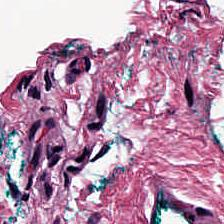

<class 'dict'> tf.Tensor(1, shape=(), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'>


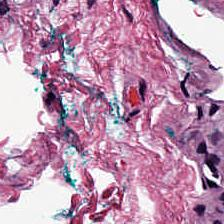

<class 'dict'> tf.Tensor(2, shape=(), dtype=int64) <class 'tensorflow.python.framework.ops.EagerTensor'>


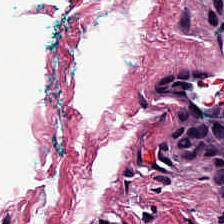

In [35]:
# tfr_name = 'CMU-1-Small-Region.tfrecords' # bad tpye height & width
tfr_name = '../../DigiPath_MLTK_data/module_test/CMU-1-Small-Region.tfrecords'
raw_image_dataset = tf.data.TFRecordDataset(tfr_name)
# raw_image_dataset = tf.data.get_output_classes('slide_images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
type(parsed_image_dataset)


n_to_show = 3
for dakine in parsed_image_dataset.take(n_to_show):
    print(type(dakine), dakine['label'], type(dakine['image_raw']))
    image_raw = dakine['image_raw'].numpy()
    ip_display.display(ip_display.Image(data=image_raw))
